<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/population_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
output_score_file = 'population_score.csv'

## 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(df_pop_master.shape)

(3145, 32)


In [7]:
df_pop_master.columns

Index(['地域ID', '市区町村名', '町名', '町丁目', '人口総数（人）', '面積（km2）', '0〜4歳（人）',
       '5〜9歳（人）', '10〜14歳（人）', '15〜19歳（人）', '20〜24歳（人）', '25〜29歳（人）',
       '30〜34歳（人）', '35〜39歳（人）', '40〜44歳（人）', '45〜49歳（人）', '50〜54歳（人）',
       '55〜59歳（人）', '60〜64歳（人）', '65〜69歳（人）', '70〜74歳（人）', '75〜79歳（人）',
       '80〜84歳（人）', '85〜89歳（人）', '90〜94歳（人）', '95〜99歳（人）', '100歳以上（人）',
       '年齢不詳（人）', '平均年齢（歳）', '外国人（人）', '緯度', '経度'],
      dtype='object')

In [8]:
df_pop_master['乳幼児割合'] = (df_pop_master['0〜4歳（人）'] + df_pop_master['5〜9歳（人）'] * 1/5) / df_pop_master['人口総数（人）']
df_pop_master['小学生割合'] = (df_pop_master['5〜9歳（人）'] * 4/5 + df_pop_master['10〜14歳（人）'] * 2/5) / df_pop_master['人口総数（人）']
df_pop_master['中学生割合'] = (df_pop_master['10〜14歳（人）'] * 3/5) / df_pop_master['人口総数（人）']
df_pop_master['高校生割合'] = (df_pop_master['15〜19歳（人）'] * 3/5) / df_pop_master['人口総数（人）']
df_pop_master['10代割合'] = (df_pop_master['15〜19歳（人）'] * 2/5) / df_pop_master['人口総数（人）']
df_pop_master['20代割合'] = (df_pop_master['20〜24歳（人）'] + df_pop_master['25〜29歳（人）']) / df_pop_master['人口総数（人）']
df_pop_master['30代割合'] = (df_pop_master['30〜34歳（人）'] + df_pop_master['35〜39歳（人）']) / df_pop_master['人口総数（人）']
df_pop_master['40代割合'] = (df_pop_master['40〜44歳（人）'] + df_pop_master['45〜49歳（人）']) / df_pop_master['人口総数（人）']
df_pop_master['50代割合'] = (df_pop_master['50〜54歳（人）'] + df_pop_master['55〜59歳（人）']) / df_pop_master['人口総数（人）']
df_pop_master['60代割合'] = (df_pop_master['60〜64歳（人）'] + df_pop_master['65〜69歳（人）']) / df_pop_master['人口総数（人）']
df_pop_master['10代_子割合'] = df_pop_master['乳幼児割合']
df_pop_master['20代_子割合'] = df_pop_master['乳幼児割合'] + df_pop_master['小学生割合']
df_pop_master['30代_子割合'] = df_pop_master['乳幼児割合'] + df_pop_master['小学生割合'] + df_pop_master['中学生割合']
df_pop_master['40代_子割合'] = df_pop_master['小学生割合'] + df_pop_master['中学生割合'] + df_pop_master['高校生割合']
df_pop_master['50代_子割合'] = df_pop_master['中学生割合'] + df_pop_master['高校生割合'] + df_pop_master['10代割合']

In [9]:
feature_list = [col for col in df_pop_master.columns if col.endswith('割合')]
df_pop_rate = df_pop_master[['地域ID', '市区町村名', '町名', '町丁目', '人口総数（人）'] + feature_list].copy()
print(df_pop_rate.shape)
df_pop_rate[1000:1005]

(3145, 20)


,地域ID,市区町村名,町名,町丁目,人口総数（人）,乳幼児割合,小学生割合,中学生割合,高校生割合,10代割合,20代割合,30代割合,40代割合,50代割合,60代割合,10代_子割合,20代_子割合,30代_子割合,40代_子割合,50代_子割合
1000,109098,品川区,小山,小山７丁目,1317,0.039636,0.044343,0.024601,0.023235,0.015490,0.113895,0.132878,0.172361,0.124525,0.101746,0.039636,0.083979,0.108580,0.092179,0.063326
1001,109100,品川区,荏原,荏原１丁目,2858,0.040168,0.039188,0.017215,0.020154,0.013436,0.150455,0.201190,0.164801,0.092722,0.097271,0.040168,0.079356,0.096571,0.076557,0.050805
1002,109101,品川区,荏原,荏原２丁目,3181,0.035901,0.041245,0.019994,0.030556,0.020371,0.107513,0.125747,0.170701,0.136121,0.101855,0.035901,0.077146,0.097139,0.091795,0.070921
1003,109102,品川区,荏原,荏原３丁目,2610,0.045900,0.030498,0.014023,0.013563,0.009042,0.130651,0.220307,0.166667,0.120690,0.101149,0.045900,0.076398,0.090421,0.058084,0.036628
1004,109103,品川区,荏原,荏原４丁目,3796,0.051897,0.036143,0.016280,0.018651,0.012434,0.115121,0.194942,0.162540,0.106955,0.108799,0.051897,0.088040,0.104320,0.071075,0.047366


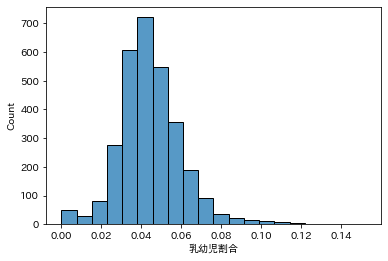

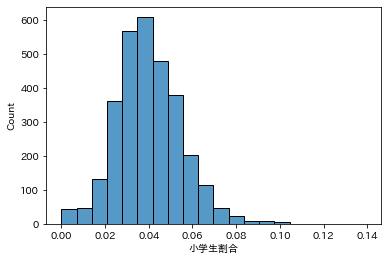

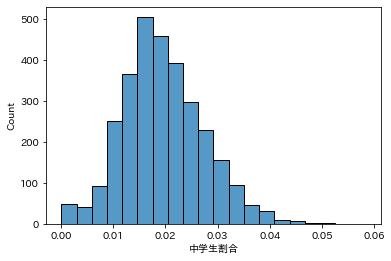

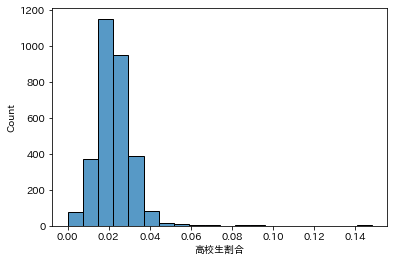

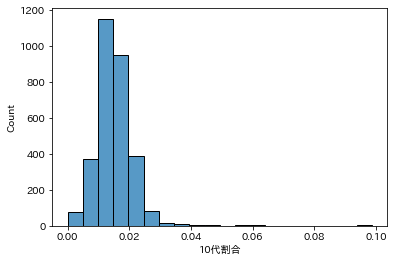

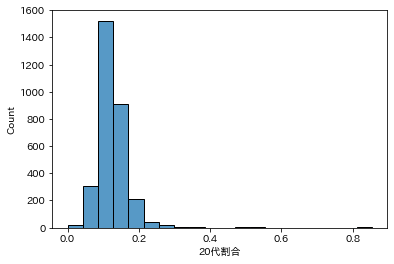

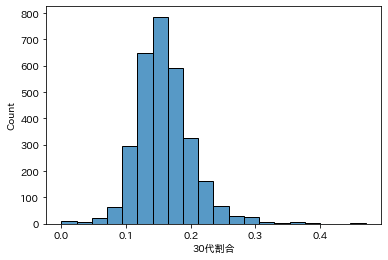

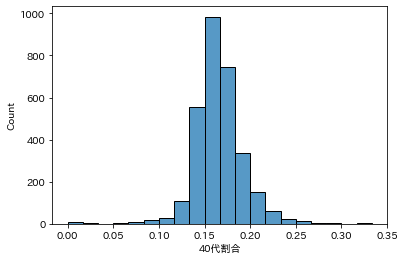

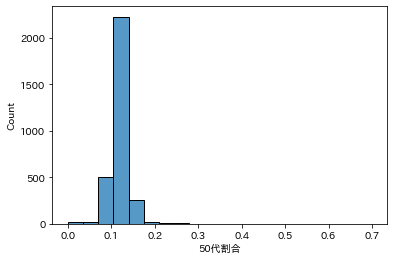

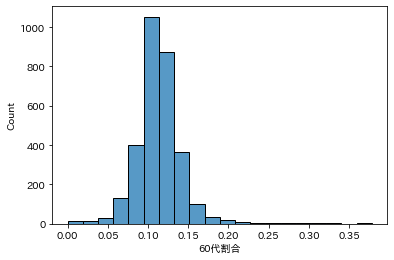

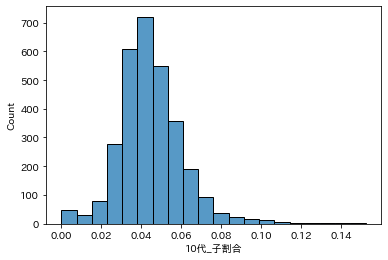

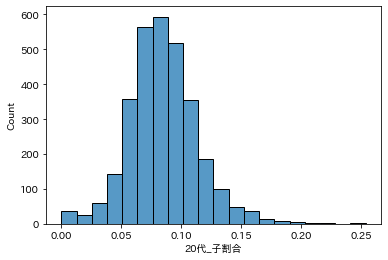

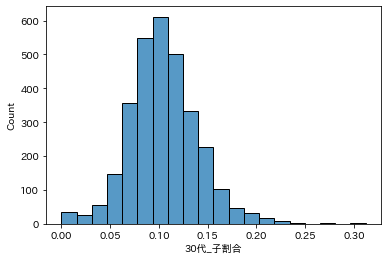

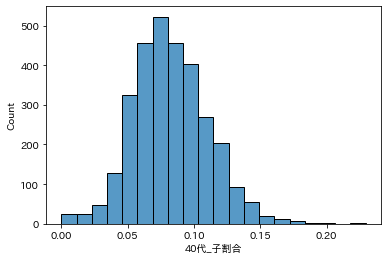

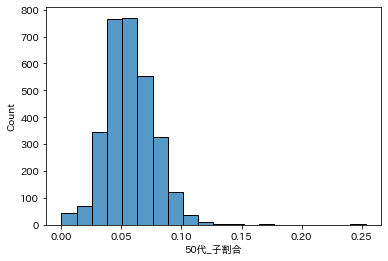

In [10]:
for feature_name in feature_list:
    sns.histplot(df_pop_rate[feature_name], bins=20)
    plt.show()

In [11]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

In [12]:
for feature_name in feature_list:
    df_pop_rate[feature_name + 'スコア'] = rank_score(df_pop_rate[feature_name]).round(3)

score_list = [col + 'スコア' for col in feature_list]

In [13]:
df_pop_rate[['地域ID', '市区町村名', '町名', '町丁目', '小学生割合スコア']].sort_values('小学生割合スコア', ascending=False).head(10)

,地域ID,市区町村名,町名,町丁目,小学生割合スコア
3074,123156,江戸川区,東篠崎,東篠崎２丁目,5.000
1943,116007,豊島区,駒込,駒込５丁目,4.998
2142,118010,荒川区,南千住,南千住８丁目,4.996
907,108182,江東区,新砂,新砂２丁目,4.993
1554,112243,世田谷区,千歳台,千歳台６丁目,4.991
261,103062,港区,元麻布,元麻布２丁目,4.989
2938,122176,葛飾区,南水元,南水元３丁目,4.987
1673,113049,渋谷区,代々木神園町,代々木神園町,4.985
2892,122123,葛飾区,細田,細田２丁目,4.983
885,108157,江東区,北砂,北砂２丁目,4.980


In [14]:
df_pop_rate[['地域ID', '市区町村名', '町名', '町丁目', '20代割合スコア']].sort_values('20代割合スコア', ascending=False).head(10)

,地域ID,市区町村名,町名,町丁目,20代割合スコア
827,108086,江東区,有明,有明３丁目,5.000
32,101042,千代田区,千代田,千代田,4.998
213,102123,中央区,水面,水面,4.996
2402,120104,練馬区,北町,北町４丁目,4.993
528,105058,文京区,本郷,本郷７丁目,4.991
835,108097,江東区,青海,青海２丁目,4.989
573,106030,台東区,秋葉原,秋葉原,4.987
140,102033,中央区,築地,築地５丁目,4.985
910,108186,江東区,新木場,新木場２丁目,4.983
62,101082,千代田区,神田駿河台,神田駿河台２丁目,4.980


In [15]:
df_pop_rate[['地域ID', '市区町村名', '町名', '町丁目', '20代_子割合スコア']].sort_values('20代_子割合スコア', ascending=False).head(10)

,地域ID,市区町村名,町名,町丁目,20代_子割合スコア
3074,123156,江戸川区,東篠崎,東篠崎２丁目,5.000
1943,116007,豊島区,駒込,駒込５丁目,4.998
2056,117044,北区,十条台,十条台２丁目,4.996
212,102122,中央区,晴海,晴海５丁目,4.993
822,108079,江東区,豊洲,豊洲６丁目,4.991
3046,123121,江戸川区,鹿骨町,鹿骨町,4.989
1673,113049,渋谷区,代々木神園町,代々木神園町,4.987
2652,121162,足立区,千住緑町,千住緑町１丁目,4.985
819,108076,江東区,豊洲,豊洲３丁目,4.983
825,108084,江東区,有明,有明１丁目,4.980


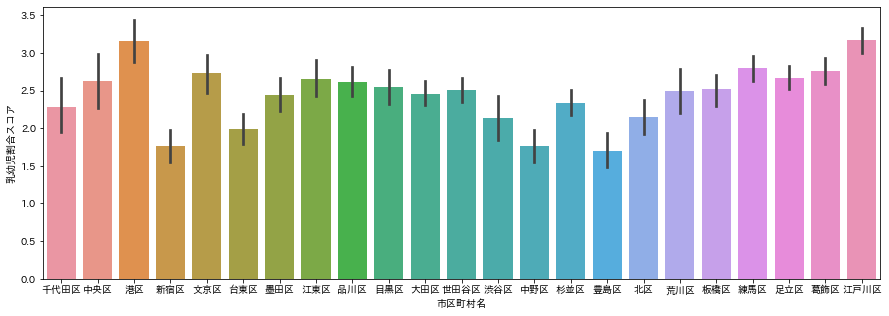

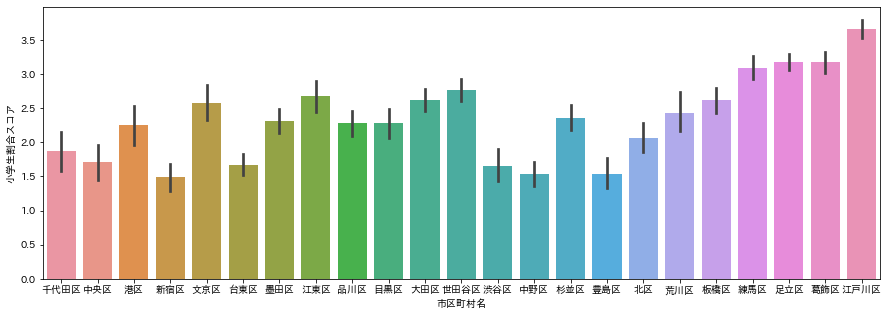

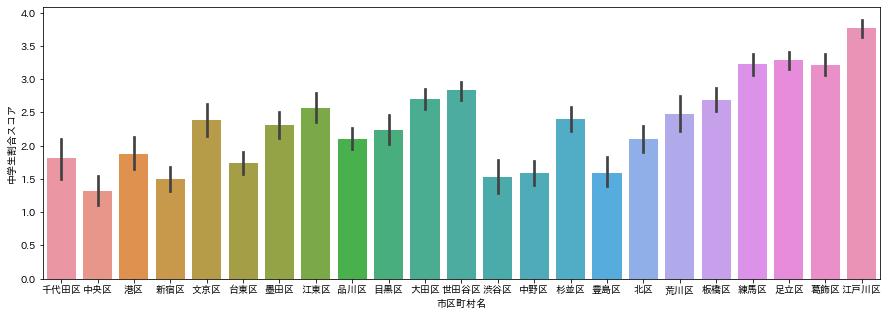

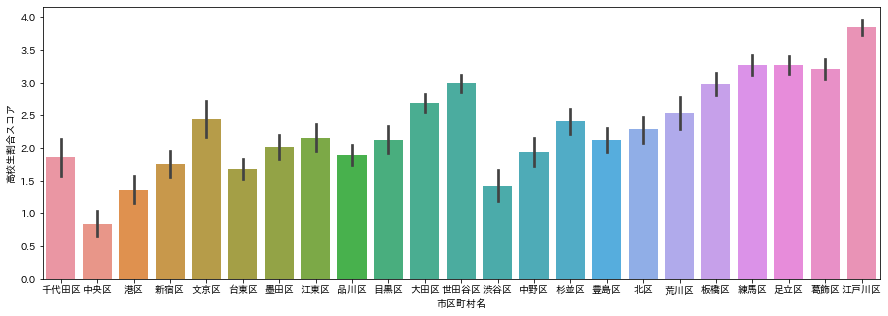

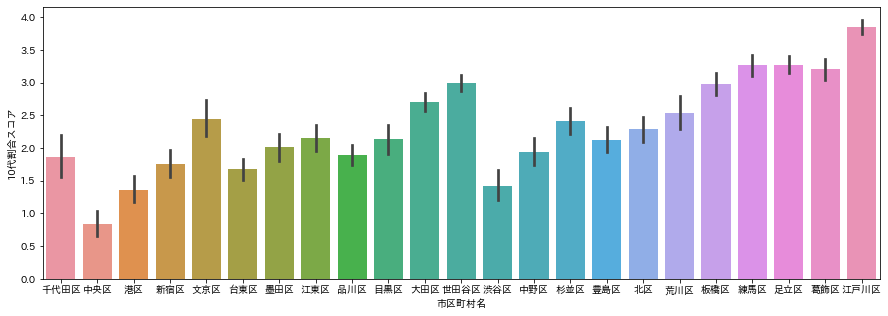

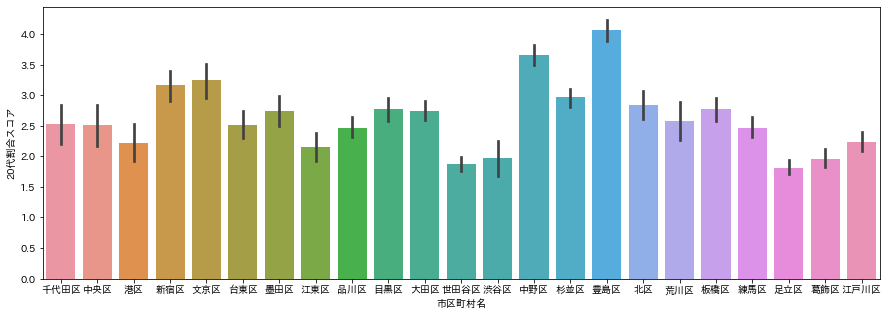

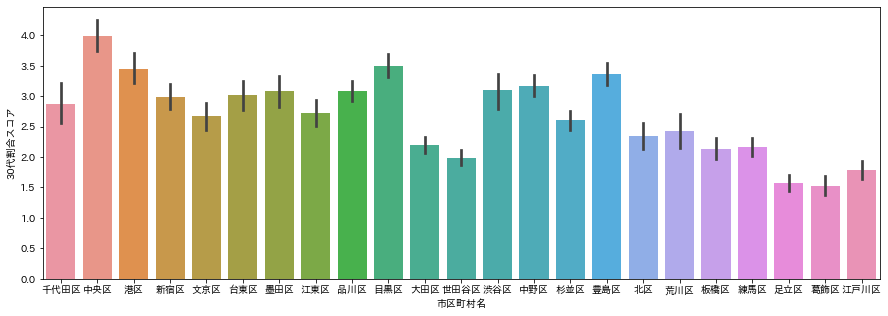

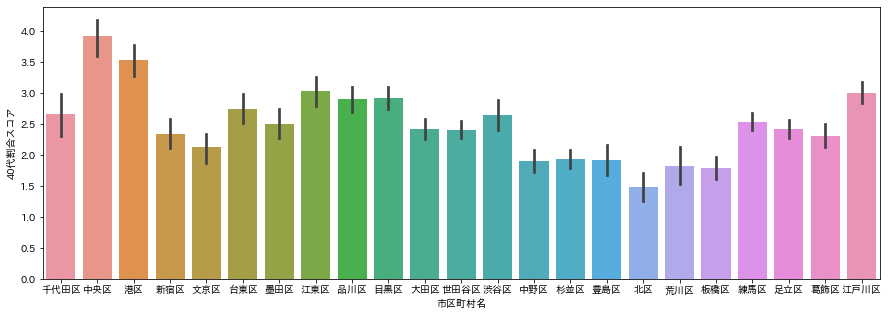

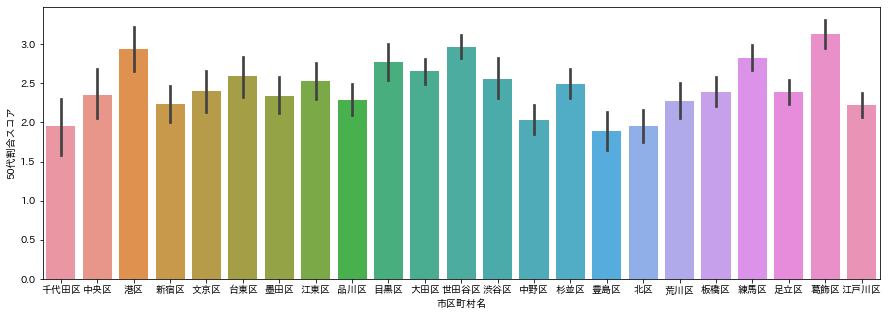

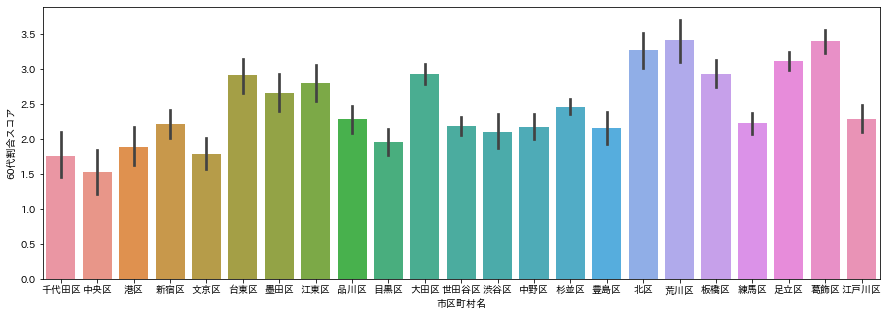

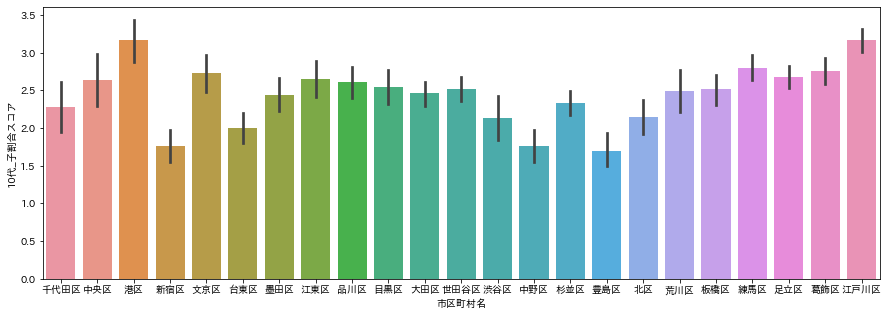

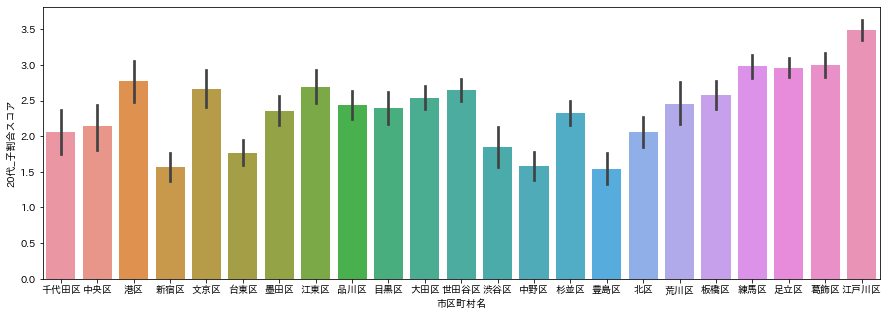

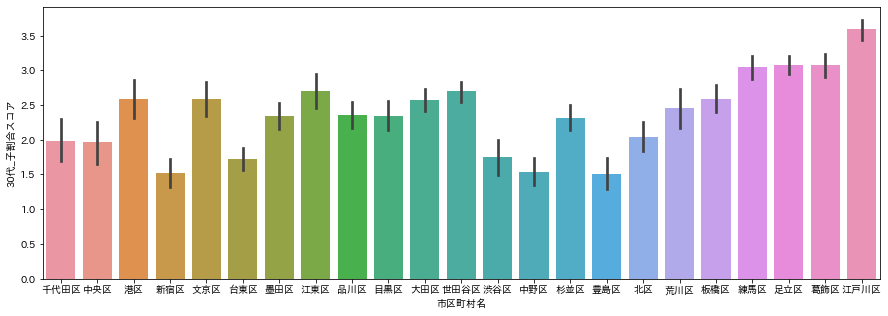

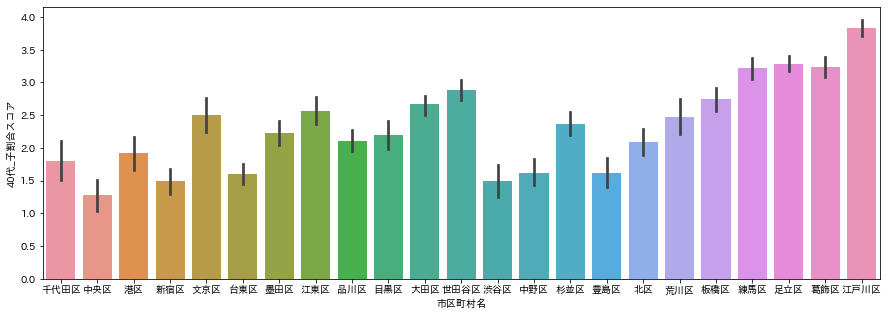

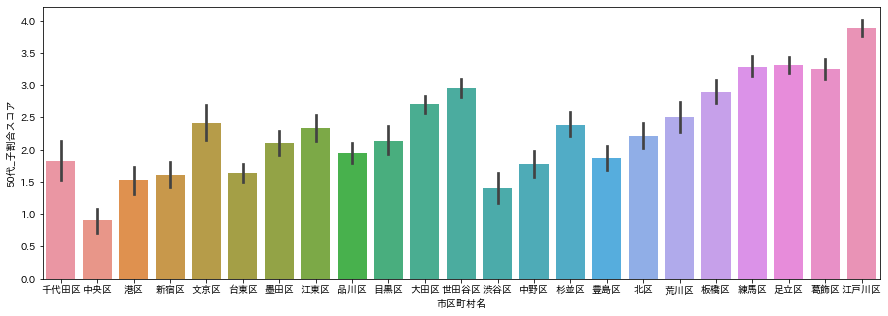

In [16]:
for score_name in score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score_name, data=df_pop_rate)
    plt.show()

### 保存

In [17]:
df_pop_rate[['地域ID'] + score_list].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)